In [1]:
# Import Required Libraries
library(dplyr)
library(tsibble)
library(fable)
library(ggplot2)
library(tidyr)
library(purrr)
library(feasts)

# Source Helper Functions
source("../Baseline/baseline_helpers.R")
source("../Data_Inspection/data_cleaning_helpers.R")
source("./evaluation_helpers.R")


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 method overwritten by 'tsibble':
  method               from 
  as_tibble.grouped_df dplyr


Attaching package: ‘tsibble’


The following objects are masked from ‘package:base’:

    intersect, setdiff, union


Loading required package: fabletools


Attaching package: ‘lubridate’


The following object is masked from ‘package:tsibble’:

    interval


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union




In [2]:
#library(future)

In [3]:
#workers <- parallel::detectCores() - 1

## Load data

In [4]:
# Load dates
dates <- read.csv("../calendar_afcs2025.csv") |> mutate(date = as.Date(date, format = "%m/%d/%Y"))
dates <- dates |> rename(day = date)

# added this later, might break everything, gotta check it
dates <- dates |> as_tsibble(index = day, key = wm_yr_wk)

# adding dummy variables for each weekday
dates <- dates |>
  mutate(
    wd_monday    = as.integer(weekday == "Monday"),
    wd_tuesday   = as.integer(weekday == "Tuesday"),
    wd_wednesday = as.integer(weekday == "Wednesday"),
    wd_thursday  = as.integer(weekday == "Thursday"),
    wd_friday    = as.integer(weekday == "Friday"),
    wd_saturday  = as.integer(weekday == "Saturday")
  )

dates <- dates |>
  mutate(
    m_january   = as.integer(month == 1),
    m_february  = as.integer(month == 2),
    m_march     = as.integer(month == 3),
    m_april     = as.integer(month == 4),
    m_may       = as.integer(month == 5),
    m_june      = as.integer(month == 6),
    m_july      = as.integer(month == 7),
    m_august    = as.integer(month == 8),
    m_september = as.integer(month == 9),
    m_october   = as.integer(month == 10),
    m_november  = as.integer(month == 11)
  )

# way too many unique event names so many we just focus on this,
# it's implemented with an or because event1 and event2 are always different type,
# and they can be in either order

# adding dummy variables for each event category
dates <- dates |>
  mutate(
    et_sporting  = as.integer((event_type_1 == "Sporting" | event_type_2 == "Sporting") %in% TRUE),
    et_cultural  = as.integer((event_type_1 == "Cultural" | event_type_2 == "Cultural") %in% TRUE),
    et_national  = as.integer((event_type_1 == "National" | event_type_2 == "National") %in% TRUE),
    et_religious = as.integer((event_type_1 == "Religious" | event_type_2 == "Religious") %in% TRUE)
  )


In [5]:
# Load train data
train <- get_train_and_validation_data_concatted(dates)

# Clean evaluation data
test <- get_evaluation_data()


In [6]:
train

day,product,sales,wm_yr_wk,weekday,wday,month,year,event_name_1,event_type_1,⋯,m_august,m_september,m_october,m_november,et_sporting,et_cultural,et_national,et_religious,sell_price,log_sales
<date>,<chr>,<dbl>,<int>,<chr>,<int>,<int>,<int>,<chr>,<chr>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>
2011-01-29,FOODS_3_001,0.0000000,11101,Saturday,1,1,2011,NA,NA,⋯,0,0,0,0,0,0,0,0,2.28,0.0000000
2011-01-30,FOODS_3_001,1.0986123,11101,Sunday,2,1,2011,NA,NA,⋯,0,0,0,0,0,0,0,0,2.28,1.0986123
2011-01-31,FOODS_3_001,0.6931472,11101,Monday,3,1,2011,NA,NA,⋯,0,0,0,0,0,0,0,0,2.28,0.6931472
2011-02-01,FOODS_3_001,1.3862944,11101,Tuesday,4,2,2011,NA,NA,⋯,0,0,0,0,0,0,0,0,2.28,1.3862944
2011-02-02,FOODS_3_001,0.0000000,11101,Wednesday,5,2,2011,NA,NA,⋯,0,0,0,0,0,0,0,0,2.28,0.0000000
2011-02-03,FOODS_3_001,0.0000000,11101,Thursday,6,2,2011,NA,NA,⋯,0,0,0,0,0,0,0,0,2.28,0.0000000
2011-02-04,FOODS_3_001,0.6931472,11101,Friday,7,2,2011,NA,NA,⋯,0,0,0,0,0,0,0,0,2.28,0.6931472
2011-02-05,FOODS_3_001,0.0000000,11102,Saturday,1,2,2011,NA,NA,⋯,0,0,0,0,0,0,0,0,2.28,0.0000000
2011-02-06,FOODS_3_001,1.0986123,11102,Sunday,2,2,2011,SuperBowl,Sporting,⋯,0,0,0,0,1,0,0,0,2.28,1.0986123


## Baselines

Mean

In [7]:
means <- train |>
  as_tibble() |>
  group_by(product) |>
  summarise(mean_sales = mean(sales))

mean_forecasts <- new_data(ungroup(train), n = 28) |>
  left_join(means, by = "product") |>
  rename(sales = mean_sales) |>
  as_tibble()

aligned_data <- align_predictions(mean_forecasts, test)
accuracy_mean <- calculate_metrics(aligned_data)

Naive

In [8]:
path <- "models/baseline/naive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  print("Creating new model")
  fit <- train |>
    model(
      NAIVE(sales)
    )
  saveRDS(fit, path)
}


naive_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(naive_forecasts, test)
accuracy_naive <- calculate_metrics(aligned_data)
naive_augmented <- fit |> augment()

[1] "Creating new model"


sNaive

In [9]:
path <- "models/baseline/snaive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  print("Creating new model")
  fit <- train |>
    model(
      SNAIVE(sales)
    )
  saveRDS(fit, path)
}

snaive_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(snaive_forecasts, test)
accuracy_snaive <- calculate_metrics(aligned_data)
snaive_augmented <- fit |> augment()


[1] "Creating new model"


ARIMA

In [10]:
path <- "models/baseline/arima.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  #plan(multisession, workers = workers) # Worker function for parallel processing
  print("Creating new model")
  fit <- train |>
    model(
      ARIMA(sales)
    )
  saveRDS(fit, path)
  #plan(sequential)
}

arima_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(arima_forecasts, test)
accuracy_arima <- calculate_metrics(aligned_data)
arima_augmented <- fit |> augment()

[1] "Creating new model"


Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning message in sqrt(diag(best$var.coef)):
“NaNs produced”
Warning 

ETS

In [11]:
path <- "models/baseline/ets.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  print("Using existing model")
  fit <- readRDS(path)
} else {
  #plan(multisession, workers = workers) # Worker function for parallel processing
  print("Creating new model")
  fit <- train |>
    model(
      ETS(sales)
    )
  saveRDS(fit, path)
  #plan(sequential)
}

ets_forecasts <- fit |>
  forecast(h = 28) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  #mutate(sales = .mean) |>
  select(-.model, -.mean)


aligned_data <- align_predictions(ets_forecasts, test)
accuracy_ets <- calculate_metrics(aligned_data)
ets_augmented <- fit |> augment()

[1] "Creating new model"


In [12]:
head(ets_forecasts)

product,day,sales
<chr>,<date>,<dbl>
FOODS_3_001,2016-05-23,0.2550189
FOODS_3_001,2016-05-24,0.3666531
FOODS_3_001,2016-05-25,0.1814738
FOODS_3_001,2016-05-26,0.2583765
FOODS_3_001,2016-05-27,0.2930663
FOODS_3_001,2016-05-28,0.3221210


Evaluate baselines

# A tibble: 5 × 3
  model   RMSE   MAE
  <chr>  <dbl> <dbl>
1 mean    6.13  2.13
2 naive   4.66  2.05
3 snaive  4.14  1.86
4 arima   3.73  1.54
5 ets     3.71  1.55


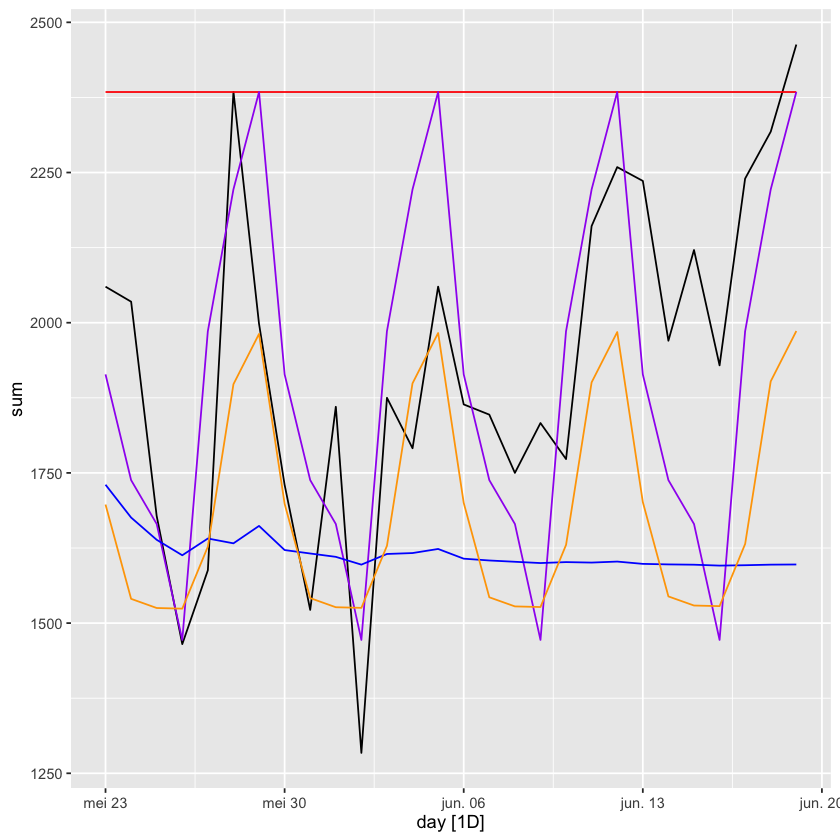

In [13]:
sums_mean <- mean_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_naive <- naive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_arima <- arima_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_ets <- ets_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

sums_test <- test |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales))

# accuracy table
baseline_accuracy <- bind_rows(
  mean = accuracy_mean,
  naive = accuracy_naive,
  snaive = accuracy_snaive,
  arima = accuracy_arima,
  ets = accuracy_ets,
  .id = "model"
)

print(baseline_accuracy)

# plotting against validation to see what is being captured
(sums_test |> autoplot(.vars = sum)) +
  autolayer(sums_naive, sum, color = "red") +
  autolayer(sums_snaive, sum, color = "purple") +
  autolayer(sums_arima, sum, color = "blue") +
  autolayer(sums_ets, sum, color = "orange")


## ARIMA

In [ ]:
path <- "models/arima_model.rds"

if (file.exists(path)) {
  arima_fit <- readRDS(path)
} else {
  arima_fit <- train |>
    model(
      ARIMA(sales ~ sell_price)
    )

  saveRDS(arima_fit, path)
}


sNaive price performs best

In [ ]:
path <- "models/prices/snaive.rds"

# load fit or fit it and store the fit
if (file.exists(path)) {
  price_fit_snaive <- readRDS(path)
} else {
  # fitting a seasonal naive
  price_fit_snaive <- train |>
    model(SNAIVE(sell_price))

  saveRDS(price_fit_snaive, path)
}

# forecast price
sell_price_future_snaive <- price_fit_snaive |>
  forecast(h = "28 days") |>
  as_tsibble() |>
  select(product, day, .mean) |>
  rename(sell_price = .mean)

# forecast sales based on this price as future data
snaive_forecasts <- forecast(arima_fit, new_data = sell_price_future_snaive) |>
  as_tibble() |>
  mutate(sales = exp(.mean) - 1) |>
  select(day, product, sales)


aligned_data <- align_predictions(snaive_forecasts, validation)
accuracy_snaive <- calculate_metrics(aligned_data)


In [ ]:
sums_snaive <- snaive_forecasts |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

sums_val <- validation_filtered |>
  as_tsibble(index = day, key = product) |>
  index_by(day) |>
  summarise(sum = sum(sales, na.rm = TRUE))

# accuracy table
dynamic_price_accuracy <- bind_rows(
  snaive = accuracy_snaive,
  .id = "model"
)

print(dynamic_price_accuracy)

# plotting against validation to see what is being captured
(sums_val |> autoplot(.vars = sum)) +
  autolayer(sums_snaive, sum, color = "red")

## Hurdle